# HQNSL for 1-qubit operations
This notebook is a test of the HQNSL scheme for the simplest parametrization of a quantum circuit: a set of `L` 1-qubit rotations given by `L * 3` parameters. We will learn in 2 bases and examine the effectiveness of the algorithm.

In [1]:
from __helpers import qubit_expansion, rand_basis
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
%matplotlib inline

## Construction of the State

      ┌───┐          
q0_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q0_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q0_2: ──────────┤ X ├
                └───┘


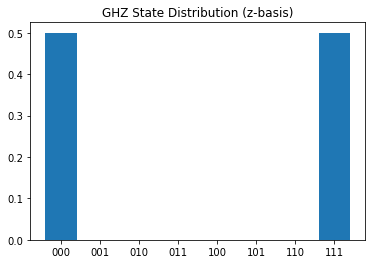

In [2]:
STATE_TYPE = 'GHZ'
if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**3)
    qc = GHZ_state_circuit()
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(3) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(3).numpy()) # L = 3 qubits
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(3) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**9)
    qc = cluster_state_circuit(3)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{STATE_TYPE} State Distribution (z-basis)")
plt.show()

## HQN Training
We will construct the bases we want as a list of `L x 3` rotation-parameter matrices, then pass them into the hybrid quantum net and run the optimization algorithm. 

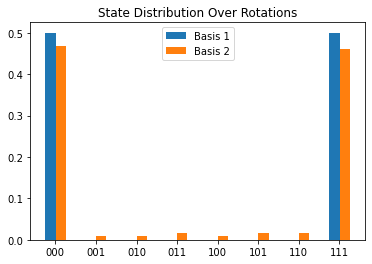

In [3]:
# Preparation of two bases
init_basis = t.zeros(state.num_qubits, 3) # z-basis
perturbation = init_basis.clone()
perturbation[:,0] += pi/10 * t.ones(3) # small rotation in one axis for each qubit
perturbed_basis = init_basis + perturbation
bases = [init_basis, perturbed_basis]
num_bases = len(bases)

# Visualize the distribution of the bases
fig, ax = plt.subplots()
for i, basis in enumerate(bases):
    dist_i = BasisTransformer([state], basis).updated_dist()[0]
    bar = ax.bar(np.arange(2**state.num_qubits) + 0.25*i - 0.04*state.num_qubits, dist_i, width=0.25)
    bar.set_label(f"Basis {i+1}")
plt.legend()
ax.set_xticks(np.arange(2**state.num_qubits))
ax.set_xticklabels(qubit_expansion(state.num_qubits))
plt.title("State Distribution Over Rotations")
plt.show()

In [8]:
# Start up the HQN
hqn = HQNet(state, bases, metric_func=KL, regularize=False)

options = {
    'num_epochs': 30,  # FDSGD: number of training epochs (each epoch has a new random param set
    'h': 0.05,       # FGSGD: finite difference step parameter
    'max_iter': 200   # FGSGD: maximum iterations per epoch
}

Classical deep net initialized.
Classical deep net initialized.
Parametrized quantum circuit initialized.
Parametrized quantum circuit initialized.
Non-regularized hybrid quantum net initialized -- Hello world!


== Run 1/1 ==
[Epoch 1] FDSGD failed to converge on parameter 7 within 200 steps. Grad = -0.0005054473876953125
[Epoch 2] FDSGD failed to converge on parameter 4 within 200 steps. Grad = -0.0002384185791015625
[Epoch 4] FDSGD failed to converge on parameter 1 within 200 steps. Grad = -0.00020503997802734375
[Epoch 5] FDSGD failed to converge on parameter 4 within 200 steps. Grad = 0.0005578994750976562
[Epoch 7] FDSGD failed to converge on parameter 4 within 200 steps. Grad = -0.07905006408691406
[Epoch 8] FDSGD failed to converge on parameter 8 within 200 steps. Grad = 0.03396749496459961
[Epoch 9] FDSGD failed to converge on parameter 2 within 200 steps. Grad = 0.1355910301208496
[Epoch 10] FDSGD failed to converge on parameter 1 within 200 steps. Grad = -0.00024080276489257812
[Epoch 11] FDSGD failed to converge on parameter 8 within 200 steps. Grad = -0.007529258728027344
[Epoch 12] FDSGD failed to converge on parameter 7 within 200 steps. Grad = 0.0050449371337890625
[Epoch 13] FD

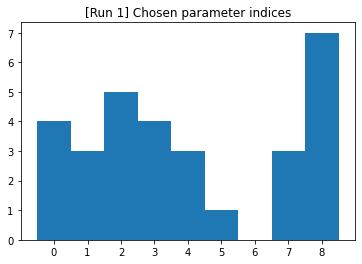

In [44]:
# Optimize a few times.
NRUN = 1
param_dim = state.num_qubits * 3
proposed_syms = t.zeros((NRUN, param_dim)) #* parametrization-dependent
for i in range(NRUN):
    print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, idx_dist = hqn.find_potential_symmetry(algo_ops=options)
    proposed_syms[i] = t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape((state.num_qubits, 3)) #* parametrization-dependent
    print(f"Proposed symmetry:\n{potential_sym}\n")
    
    plt.clf()
    plt.hist(idx_dist, np.arange(param_dim+1) - 0.5)
    plt.title(f"[Run {i+1}] Chosen parameter indices")
    plt.xlim([-1, param_dim])
    plt.xticks(range(param_dim))
    plt.show()

In [45]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape((state.num_qubits, 3))}\n")
    for basis_here in bases:
        loss_metric = PQC(state, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for training basis {basis_here[0]} is: {loss_metric}")

Analysing proposed symmetry 1:
tensor([[8.3284, 2.0070, 2.2070],
        [2.1647, 6.0791, 4.5707],
        [3.7385, 3.9643, 0.2778]])

	Loss metric for training basis tensor([0., 0., 0.]) is: 0.656250582707162
	Loss metric for training basis tensor([0.3142, 0.0000, 0.0000]) is: 0.6595270184249615


## Quantum Loss Cross-Validation
We chose a small number of bases to run the quantum loss scheme over. But are those bases enough? 
If the proposed symmetries are truly symmetries, then they will be a symmetry in every basis. We shall test
these proposed symmetries by choosing some random bases, applying the quantum circuit, and examining the loss metric there.

If the loss metric is high there, then we did not use enough bases in the quantum loss function.

Note that this has more general implications, as the number of bases necessary to achieve a good quantum loss function
informs the amount of information necessary to construct a reasonable tomography of the state.

In [46]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    if i > 0:
        print("\n")
    print(f"Analysing proposed symmetry {i+1}:\n{sym.reshape((state.num_qubits, 3))}\n")
    for _ in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, basis_param=basis_here, metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"\tLoss metric for random basis {basis_here[0].numpy()} is: {loss_metric}")
    print('\n')

Analysing proposed symmetry 1:
tensor([[8.3284, 2.0070, 2.2070],
        [2.1647, 6.0791, 4.5707],
        [3.7385, 3.9643, 0.2778]])

	Loss metric for random basis [5.611537  1.1469742 0.8126533] is: 0.12916247100276818
	Loss metric for random basis [2.9864113  1.6486754  0.24533245] is: 0.4932633381687657
	Loss metric for random basis [1.7819146 2.238842  2.789406 ] is: 0.6853973400653468


